## Distance to nearest linestring from a point

These are some simple explorations on a constructed example

There are two broad methods here

1.  Calculate distance from point to nearest point along a bikepath (using shapely's `project`)

2. (less promising) convert linestrings to points and then use nearest neighbors.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString, mapping
from shapely.ops import nearest_points
import geopandas as gpd
import pandas as pd

#### Make up some paths

In [2]:
path1 = LineString([
    Point(0, 0),
    Point(0, 1),
    Point(1, 1),
    Point(1, 2),
    Point(3, 3),
    Point(5, 6),
])

path2 = LineString([
    Point(5, 3),
    Point(5, 5),
    Point(9, 5),
    Point(10, 7),
    Point(11, 8),
    Point(12, 12),
])

path3 = LineString([
    Point(9, 10),
    Point(10, 14),
    Point(11, 12),
    Point(12, 15),
])

In [3]:
gdf = gpd.GeoDataFrame([path1, path2, path3], columns=['geometry'])

In [4]:
gdf['pathname'] = ['path1', 'path2', 'path3']

In [5]:
gdf

,geometry,pathname
0,"LINESTRING (0 0, 0 1, 1 1, 1 2, 3 3, 5 6)",path1
1,"LINESTRING (5 3, 5 5, 9 5, 10 7, 11 8, 12 12)",path2
2,"LINESTRING (9 10, 10 14, 11 12, 12 15)",path3


Here are the made up paths:

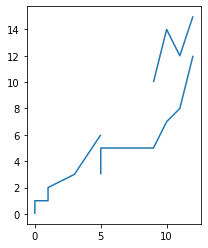

In [6]:
gdf.plot();

Let's limit our search to a buffer around a point

In [7]:
p = Point(0,5)

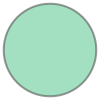

In [8]:
r  = 12 #buffer radius
B = p.buffer(r)
B

We can find a closest point on each path like this

In [9]:
C1 = nearest_points(path1, p)[0]
C2 = nearest_points(path2, p)[0]
C3 = nearest_points(path3, p)[0]

In [10]:
print(C1, C2, C3)

POINT (1.4 2.2) POINT (5 5) POINT (9 10)


Note this is equivalent to the more wordy method:

In [11]:
D = path1.interpolate(path1.project(p)) 
print(D)

POINT (1.4 2.2)


Let's plot things on matplotlib to visualize what's going on.

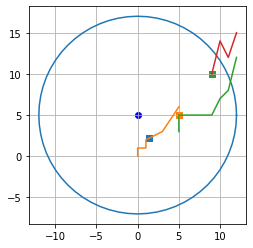

In [12]:
x1,y1 = path1.xy
x2,y2 = path2.xy
x3,y3 = path3.xy
xB,yB = B.exterior.xy

plt.plot(xB,yB)
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)
plt.scatter(p.x,p.y, color="b")  # point is blue

plt.scatter(C1.x,C1.y, marker="s")  # plot closest point on each path
plt.scatter(C2.x,C2.y, marker="s")
plt.scatter(C3.x,C3.y, marker="s")

plt.grid()
ax = plt.gca()
ax.set_aspect("equal")


Let us just search over linestrings that fall in the buffer (returned as a new dataframe).

In [13]:
gdf.geometry.intersection(p.buffer(4))

0    (POINT (6.462178297730347e-15 1), LINESTRING (...
1                                                   ()
2                                                   ()
dtype: object

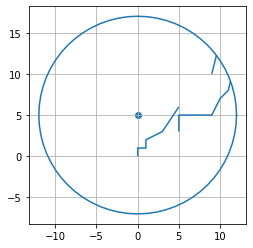

In [14]:
plt.plot(xB,yB)
plt.scatter(p.x,p.y)
plt.grid()
ax=plt.gca()
gdf.geometry.intersection(p.buffer(r)).plot(ax=ax);

Simple loop to find distances from point to lines in this buffer

In [15]:
for line in gdf.geometry:
    if not line.is_empty:
        print(line.project(p))

3.447213595499958
2.0
0.0


I'm a bit puzzled as to what these distances represent.  They do not seem to be Euclidean distances. 

This is obviously incomplete (we need code to loop through all the bikepaths) and then return the nearest distance but it would probably use these building blocks.

See Jeremy's notebook https://github.com/jeremysze/GIS_exploration/blob/master/code/snapping_points_to_line.ipynb
on using the above for a 'snap to grid' function.

## Elements of an abandoned method

Ignore what follows.  I abandoned this method after realizing that a bikepath is not just the vertices that define the line (so previous method better).  But I learned some tricks in my explorations, so I've kept the code in case they ever come in handy.

### From linestring back to points

[This stackexchange answer](https://gis.stackexchange.com/questions/238533/how-do-i-extract-points-from-a-linestring-or-polygon-data-frame-and-make-a-dicti) shows how to convert from a linestring into a list of points lists.

In [16]:
def linestring_to_points(feature, line):
    return np.array(line.coords)

gdf['points'] = gdf.apply(lambda line: linestring_to_points(line['pathname'],line['geometry']),axis=1)

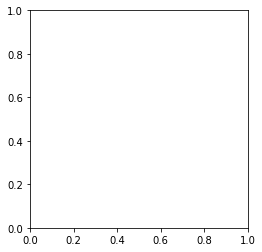

In [17]:
gdf.geometry.intersection(p.buffer(4)).plot();

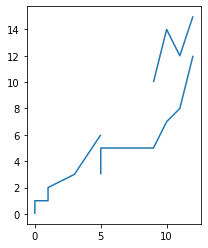

In [18]:
gdf.plot();

After some further searching I found that I can use numpy concatenate to get all the points into a stacked numpy array.

In [19]:
np.concatenate(gdf.points)

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 1.,  1.],
       [ 1.,  2.],
       [ 3.,  3.],
       [ 5.,  6.],
       [ 5.,  3.],
       [ 5.,  5.],
       [ 9.,  5.],
       [10.,  7.],
       [11.,  8.],
       [12., 12.],
       [ 9., 10.],
       [10., 14.],
       [11., 12.],
       [12., 15.]])

We can turn these back into shapely points

In [20]:
gpd.GeoSeries(map(Point,np.concatenate(gdf.points)))

0       POINT (0 0)
1       POINT (0 1)
2       POINT (1 1)
3       POINT (1 2)
4       POINT (3 3)
5       POINT (5 6)
6       POINT (5 3)
7       POINT (5 5)
8       POINT (9 5)
9      POINT (10 7)
10     POINT (11 8)
11    POINT (12 12)
12     POINT (9 10)
13    POINT (10 14)
14    POINT (11 12)
15    POINT (12 15)
dtype: object

We will want to create a new dataframe with these points but we need to label them correctly with their corresponding bike path name.  The numpy `repeat` function allows us to repeat the line name the correct number of times. 

In [21]:
np.repeat(gdf.pathname.values, gdf.points.apply(len))

array(['path1', 'path1', 'path1', 'path1', 'path1', 'path1', 'path2',
       'path2', 'path2', 'path2', 'path2', 'path2', 'path3', 'path3',
       'path3', 'path3'], dtype=object)

So finally, let's create a dataframe that lists points and associated bike paths.

In [22]:
pathpts = pd.DataFrame({ 'path': np.repeat(gdf.pathname.values, gdf.points.apply(len)),
                      'pt': gpd.GeoSeries(map(Point,np.concatenate(gdf.points)))
                   }  )
pathpts

,path,pt
0,path1,POINT (0 0)
1,path1,POINT (0 1)
2,path1,POINT (1 1)
3,path1,POINT (1 2)
4,path1,POINT (3 3)
5,path1,POINT (5 6)
6,path2,POINT (5 3)
7,path2,POINT (5 5)
8,path2,POINT (9 5)
9,path2,POINT (10 7)
